In [ ]:
#Github Repo: https://github.com/candizd/BachelorArbeit/blob/main/Bachelor.ipynb

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import time

random.seed(42)

POPULATION_SIZE = 3000
number_of_parents = 200
CROSSOVER_RATE = 0.7
MUTATION_RATE = 0.3
EPOCHS = 750
class Classroom:
    def __init__(self, name, capacity, room_type):
        self.name = name
        self.capacity = capacity
        self.room_type = room_type
    def __str__(self):
        return f"Classroom {self.name} (Capacity: {self.capacity}, Type: {self.room_type})"

class Professor:
    def __init__(self, name, preferred_days=[]):
        self.name = name
        self.preferred_days = preferred_days

class Assistant:
    def __init__(self, name):
        self.name = name

class Lesson:
    def __init__(self, code, teacher, name, is_online, class_type, preferred_days=[], timeslot=None, duration=1, room_preference=[], capacity=None, section=None):
        self.code = code
        self.teacher = teacher
        self.name = name
        self.is_online = is_online
        self.class_type = class_type
        self.preferred_days = preferred_days
        self.timeslot = timeslot
        self.duration = duration
        self.room_preference = room_preference
        self.capacity = capacity
        self.section = section


    def __str__(self):
        return self.code

class ScheduledLesson:
    def __init__(self, lesson, classroom, day, start_timeslot,classroom_capacity, lesson_capacity, is_online, section):
        self.lesson = lesson
        self.classroom = classroom
        self.day = day
        self.start_timeslot = start_timeslot
        self.classroom_capacity = classroom_capacity
        self.lesson_capacity = lesson_capacity
        self.is_online = is_online
        self.section = section

    def __str__(self):
        return f"[{self.lesson.code}, {self.lesson.teacher.name}, {self.classroom.name}, {self.day}, {self.start_timeslot}, {self.classroom_capacity}, {self.lesson_capacity}, {self.is_online}, {self.section}]"

class Schedule:
    def __init__(self, scheduled_lessons):
        self.scheduled_lessons = scheduled_lessons
        self.fitness = self.calculate_fitness()

    def __str__(self):
        return "\n".join(str(sl) for sl in self.scheduled_lessons)

    def calculate_fitness(self):
        return random.random()  # Placeholder for now


class Chromosome:
    def __init__(self, schedule=None, chromosome=None):
        if schedule:
            self.schedule = schedule
            self.chromosome = schedule_to_chromosome(schedule)
        elif chromosome:
            self.schedule = None
            self.chromosome = chromosome
        else:
            raise ValueError("Schedule or chromosome must be provided.")
        self.fitness = self.calculate_fitness()
    
    def create_mutated_copy(self, mutation_rate):
        new_chromosome = self.chromosome.copy()
        if random.random() < mutation_rate:
            lesson_indices = random.sample(range(len(new_chromosome)), 3)  
            for lesson_index in lesson_indices:
                mutate_individual(new_chromosome, lesson_index)
        return Chromosome(chromosome=new_chromosome)

    def calculate_fitness(self):
        conflict_count = 0
        teacher_conflict_count = 0
        capacity_conflict_count = 0
        classroom_conflict_count = 0
        online_offline_conflict_count = 0
        type_conflict = 0

        schedule_map = {}
        teacher_map = {}
        section_map = {}

        for sl in self.chromosome:
            lesson = sl[0]
            professor = sl[1]
            classroom = sl[2]
            day = sl[3]
            timeslot = sl[4]
            classroom_capacity = sl[5]
            lesson_capacity = sl[6]
            is_online = sl[7]
            section = sl[8]

            # Check for scheduling conflicts in the timeslot
            if lesson in schedule_map.values():
                for ts in timeslot:
                    if (day, ts, section) in schedule_map and schedule_map[(day, ts, section)] == lesson:
                        conflict_count += 1
                else:
                    for ts in timeslot:
                        schedule_map[(day, ts, section)] = lesson

            if not is_online:
                if classroom in schedule_map.values():
                    for ts in timeslot:
                        if (day, ts) in schedule_map and schedule_map[(day, ts)] == classroom:
                            classroom_conflict_count += 1
                else:
                    for ts in timeslot:
                        schedule_map[(day, ts, classroom)] = classroom

            if professor in teacher_map.values():
                for ts in timeslot:
                    if (day, ts) in teacher_map and teacher_map[(day, ts)] == professor:
                        teacher_conflict_count += 1
            else:
                for ts in timeslot:
                    teacher_map[(day, ts, professor)] = professor

            if not is_online:
                if lesson_capacity > classroom_capacity:
                    capacity_conflict_count += 1 

            if lessons[lesson].class_type != classrooms[classroom].room_type:
                type_conflict += 1

            if section not in section_map:
                section_map[section] = {}
            if day not in section_map[section]:
                section_map[section][day] = []

            section_map[section][day].append((is_online, timeslot))

            for other_is_online, other_timeslot in section_map[section][day]:
                if is_online != other_is_online:    
                    current_start = timeslot[0]
                    current_end = timeslot[-1]
                    other_start = other_timeslot[0]
                    other_end = other_timeslot[-1]

                    if abs(current_start - other_end) < 2 and abs(other_start - current_end) < 2:
                        online_offline_conflict_count += 1

            section_map[section][day].append((is_online, timeslot))

        total_conflicts = (conflict_count * 0.5 + teacher_conflict_count * 1.5 + capacity_conflict_count +
                           classroom_conflict_count * 1.5 + online_offline_conflict_count * 1.5 + type_conflict // 10)

        return total_conflicts 


    def __str__(self):
        representation_str = "Numeric Representation:\n"
        for item in self.chromosome:
            representation_str += f"{item}\n"
        return representation_str + f"Fitness: {self.fitness}"

In [2]:

professors = [
    Professor("Dr. Celal Çakıroğlu", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 0
    Professor("Doç. Dr Enver Vural Yavuz", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 1
    Professor("Dr. Ömer Faruk Aydın", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 2
    Professor("Dr. Serdar Ulusoy", preferred_days=["Monday", "Tuesday", "Thursday"]), # 3
    Professor("Prof. Dr. F. RACKWITZ", preferred_days=["Tuesday", "Thursday"]), # 4
    Professor("Dr. Öğr. Üyesi Moritz BOTTS", preferred_days=["Tuesday", "Thursday"]), # 5
    Professor("Prof. Dr. Dilek ZAMANTILI NAYIR", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 6
    Professor("M. Kerem Öztürk", preferred_days=["Tuesday", "Thursday"]), # 7
    Professor("Prof. Dr. Müge KLEIN", preferred_days=["Tuesday", "Thursday"]), # 8
    Professor("Dr.Helmut Niesner", preferred_days=["Monday", "Wednesday", "Friday"]), # 9
    Professor("Prof. Dr. Wolfgang KOHN", preferred_days=["Tuesday", "Thursday"]), # 10
    Professor("Dr. Öğr. Üyesi Mehmet Hakan ÖZDEMİR", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 11
    Professor("Dr. Moritz Martin BOTTS", preferred_days=["Tuesday", "Thursday"]), # 12
    Professor("Prof. Dr. Ela Sibel BAYRAK MEYDANOĞLU", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 13
    Professor("Doç. Dr. Ulrich TAMM", preferred_days=["Monday", "Tuesday", "Thursday"]),   # 14
    Professor("Prof. Dr. Orhan KOCAGÖZ", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 15
    Professor("Prof. Dr. Sibel Özenler", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 16
    Professor("Öğr. Gör. Selahaddin SOYUDOĞRU", preferred_days=["Monday", "Tuesday", "Thursday", "Friday"]), # 17
    Professor("Öğr. Gör. Vahap Sümer Özsüer", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 18
    Professor("Dr. Öğr. Üyesi Gökhan Habiboğlu", preferred_days=["Monday", "Tuesday", "Thursday", "Friday"]), # 19
    Professor("Dr.-Ing. Sanam Moghaddamnia", preferred_days=["Monday", "Tuesday", "Thursday", "Friday"]), # 20
    Professor("Dr. Öğr. Üyesi Murat Tümer", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 21
    Professor("Prof. Dr. Cem Civelek", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]),  # 22
    Professor("Doç. Dr. Tanju Yelkenci", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 23
    Professor("Prof. Dr. Georg Duschl-Graw", preferred_days=["Tuesday", "Thursday"]), # 24
    Professor("Andrea Schwandt", preferred_days=["Tuesday", "Thursday"]), # 25
    Professor("Dr. Öğr. Üyesi Sanam Moghaddamnia", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 26
    Professor("Dr. Öğr. Üyesi Engin ARIKAN", preferred_days=["Tuesday", "Thursday"]), # 27
    Professor("Prof. Dr. Hüseyin Özcan", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 28
    Professor("Prof. Dr. Henning Rosenau", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 29
    Professor("Prof. Dr. Katharina Gelbrich", preferred_days=["Tuesday", "Thursday"]), # 30
    Professor("Dr. Taner Aydin", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 31
    Professor("Doç. Dr. M. Tolga Özer", preferred_days=["Tuesday", "Thursday"]), # 32
    Professor("Prof. Dr. Ali Kemal Yıldız", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]),  # 33
    Professor("Prof. Dr. Fatih Selami MAHMUTOĞLU", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 34
    Professor("Öğr. Gör. Dr. Ayşe Nur Saldıran", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 35
    Professor("Dr. Susanne Schuster", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 36
    Professor("Dr. Maria Liana Vodita", preferred_days=["Monday", "Tuesday", "Thursday"]), # 37
    Professor("Prof. Dr. Gerhard SEHER", preferred_days=["Tuesday", "Thursday"]), # 38
    Professor("Prof. Dr. Mesut Serdar Çekin", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 39
    Professor("Prof. Dr. İrfan AKIN", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 40
    Professor("Prof. Dr. Hamide Özden Özkaya Ferendeci", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 41
    Professor("Ralf Kanitz", preferred_days=["Monday", "Tuesday", "Thursday"]), # 42
    Professor("Dr. Taner Aydın", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 43
    Professor("Doç. Dr. Üyesi Murat Sarıkaya", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]),  # 44
    Professor("Doç. Dr. Esra YİĞİT", preferred_days=["Tuesday", "Thursday"]), # 45
    Professor("Dr. Öğretim Üyesi Melis Avşar", preferred_days=["Monday", "Wednesday", "Friday"]), # 46
    Professor("Doç. Dr. Murat Sarıkaya", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 47
    Professor("Doç. Dr. Berke Özenç", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]),  # 48
    Professor("Prof. Dr. Vural SEVEN", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 49
    Professor("Dr. Esra Yılmaz Eren", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 50
    Professor("Prof. Dr. Zafer Zeytin", preferred_days=["Tuesday", "Thursday"]), # 51
    Professor("Prof.Dr. Zafer Zeytin", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 52
    Professor("Doç. Dr. Koray DEMİR", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 53
    Professor("Dr. Hilal Ünal Kaya", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 54
    Professor("Dr. Thorsten GERDES", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 55
    Professor("Dr. Volkan Gezer (FF)", preferred_days=["Tuesday", "Thursday"]), # 56
    Professor("Prof. Dr. Barış Sertkaya (FF)", preferred_days=["Tuesday", "Thursday"]), # 57
    Professor("Prof. Dr. Mesut Güneş (FF)", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 58
    Professor("Dr. Canan Yıldız", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 59
    Professor("Dr. Emel Maden Yılmaz", preferred_days=["Tuesday", "Thursday"]), # 60
    Professor("Tobias Westphal", preferred_days=["Monday", "Wednesday", "Friday"]), # 61
    Professor("Dr. Burcu Yıldız", preferred_days=["Monday", "Tuesday", "Thursday"]), # 62
    Professor("Dr. Öğr. Üyesi Dilek Göksel Duru", preferred_days=["Monday", "Wednesday", "Friday"]), # 63
    Professor("Doç. Dr. Emre Işık", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 64
    Professor("Dipl.-Ing. J. KUNTZE", preferred_days=["Tuesday", "Thursday"]), # 65
    Professor("Dr. Öğr. Üyesi Robin Kurilla", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 66
    Professor("Prof. Dr. B. Aykut Arıkan", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 67
    Professor("Öğr. Gör. Esra JORKOWSKİ BERBEROĞLU", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 68
    Professor("Dr.Öğr. Üyesi Büşra Fadim Sarıkaya", preferred_days=["Monday", "Tuesday", "Friday"]), # 69
    Professor("Prof. Uwe Hochmuth", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 70
    Professor("Araş.Gör. Dr. İpek Kesici", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 71
    Professor("Doç. Dr. A. Elif Posos Devrani", preferred_days=["Monday", "Wednesday"]), # 72
    Professor("Dr. Muhammet Sait Duran", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 73
    Professor("Dr. Öğr. Üyesi Mehmet Gökhan Gökçen", preferred_days=["Tuesday", "Thursday"]), # 74
    Professor("Prof. Dr. Hulusi Bozkurt", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 75
    Professor("Dr. Öğr. Üyesi Mehmet İpekoğlu", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 76
    Professor("Prof. Dr. Meyer", preferred_days=["Monday", "Thursday"]), # 77
    Professor("Dr. Sungur Aytaç", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 78
    Professor("Dr. Axel Stegen", preferred_days=["Tuesday", "Thursday"]), # 79
    Professor("Prof. Dr. Konstantinos-Dionysios BOUZAKIS", preferred_days=["Monday", "Wednesday", "Friday"]), # 80
    Professor("Doç. Dr. Haydar Uncu", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 81
    Professor("Wiss. Mit. Dr. Betül Uluca", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 82
    Professor("Dr. habil. Orkide Coşkuner Weber", preferred_days=["Tuesday", "Wednesday"]), # 83
    Professor("Wiss. Mit. Melis Işık Toksoy", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 84
    Professor("Wiss. Mit. Ogün Morkoç", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 85
    Professor("Wiss. Mit. Şeyma İş", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 86
    Professor("Doç. Dr. Aysu Yarman", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 87
    Professor("Dr. Merve Budaklı", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 88
    Professor("Doç. Dr. Serhat İkizoğlu", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 89
    Professor("Dr. Öğr. Üyesi Ahmet Yıldız", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 90
    Professor("Prof. Dr. Hasan SMAJIC", preferred_days=["Tuesday", "Thursday"]), # 91
    Professor("Öğr. Gör. Ali Korucu", preferred_days=["Monday", "Wednesday", "Friday"]), # 92
    Professor("Prof.Dr.-Ing Jörg Krüger", preferred_days=["Tuesday", "Thursday"]), # 93
    Professor("Prof.Dr. Duygu Ekinci", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 94
    Professor("Assoc. Prof. Dr. Ergün Keleşoğlu", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 95
    Professor("Asist Prof.Dr. Çağatay Elibol", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 96
    Professor("Asist Prof.Dr. Çağla Söz", preferred_days=["Wednesday", "Friday"]), # 97
    Professor("Dr. Öğr. Üyesi Meltem Karaismailoğlu Elibol", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 98
    Professor("Dr. Öğr. Üyesi Kazım Çamlıbel", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 99
    Professor("Assist. Prof. Dr. Gülsüm Gündoğdu", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 100
    Professor("Assist. Prof. Dr. Bünyamin Ümsür", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 101
    Professor("Dr.Öğr. Üyesi Suna Güzin Aydemir Decker", preferred_days=["Tuesday", "Thursday"]), # 102
    Professor("Prof. Dr. Birgül Demirtaş", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 103
    Professor("Dr. Öğr. Üyesi Dominic Heinz", preferred_days=["Tuesday", "Thursday"]), # 104
    Professor("Dr. Öğr. Üyesi Philipp Decker", preferred_days=["Monday", "Friday"]), # 105
    Professor("Prof. Dr. Manuel Knoll", preferred_days=["Tuesday", "Wednesday"]), # 106
    Professor("Doç. Dr. Ebru Turhan", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 107
    Professor("Öğr. Gör. Dr. Nihan ABİR", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 108
    Professor("Dr. Öğr. Üyesi Mehtap KAYA", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 109
    Professor("Dr. Öğr. Üyesi Neşe Aral Sözener", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 110
    Professor("Dr. Alexander Opitz", preferred_days=["Monday", "Friday"]), # 111
    Professor("Prof. Dr. Martin MISSONG", preferred_days=["Tuesday", "Wednesday"]), # 112
    Professor("Prof. Dr. Aykut Kibritçioğlu", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 113
    Professor("Prof. Dr. Elif Nuroğlu", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 114
    Professor("Dr. Levent Yılmaz", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 115
    Professor("Dr. Jan Philipp Krügel", preferred_days=["Monday", "Wednesday", "Friday"]), # 116
    Professor("Dr. Christine Meemann", preferred_days=["Tuesday", "Thursday"]), # 117
    Professor("Arş. Gör. Dr. Zehra Çankaya Bayraklı", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 118
    Professor("Dr. Öğr. Üyesi Batin Latif AYLAK", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 119
    Professor("Dr. Öğr. Üyesi Önder TOMBUŞ", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 120
    Professor("Dr. Muhammed AYDEMİR", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 121
    Professor("Dr. Elisabeth STRECKER", preferred_days=["Tuesday", "Thursday"]) ,# 122
    Professor("Dr. Öğr. Üyesi Semih Emre Çekin", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 123
    Professor("Arş. Gör. Nihal Zuhal KAYALI", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 124 INF ARŞ GÖR
    Professor("Arş. Gör. F. Yeşim İKİKAT", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 125 INF ARŞ GÖR
    Professor("Arş. Gör. Fulya YENİLMEZ", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 126 INF ARŞ GÖR
    Professor("Arş. Gör. Cihan KATAR", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 127 ETE ARŞ GÖR
    Professor("Arş. Gör. Salih NİŞANCI", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 128 ETE ARŞ GÖR
    Professor("Arş. Gör. Uğur YILDIRIM", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 129 ETE ARŞ GÖR
    Professor("Arş. Gör. Ahmet YÜKSELTÜRK", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 130 WIN ARŞ GÖR
    Professor("Arş. Gör. Fatma Sena KARAL", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 131 WIN ARŞ GÖR
    Professor("Arş. Gör. Kübra YAZICI", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 132 WIN ARŞ GÖR
    Professor("Arş. Gör.  Ozan SUBAŞI ", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 133 BAU ARŞ GÖR
    Professor("Arş. Gör. Halit Emre Uygun", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 134 BAU ARŞ GÖR
    Professor("Arş. Gör.  Recep ÖZKAN", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 135 BAU ARŞ GÖR
    Professor("Arş. Gör. Mustafa Korkut ÖZARSLAN", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 136 MBT ARŞ GÖR
    Professor("Arş. Gör. Sefer Arda SERBES", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 137 MBT ARŞ GÖR
    Professor("Arş. Gör. Kerim ATMACA", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 138 MBT ARŞ GÖR
    Professor("Arş. Gör. Oğuzhan MEMİŞOĞLU", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 139 MEC ARŞ GÖR
    Professor("Arş. Gör. Onur AKGÜN", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 140 MEC ARŞ GÖR
    Professor("Arş. Gör. Osman Taha KÜTÜK", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 141 MEC ARŞ GÖR
    Professor("Arş. Gör. Ferhat SAYIN", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 142 BWL ARŞ GÖR
    Professor("Arş. Gör. Umur Ejder HALHALLI", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 143 BWL ARŞ GÖR
    Professor("Arş. Gör. Ardıl Yılmaz KAYA", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 144 BWL ARŞ GÖR
    Professor("Arş. Gör. Ayşenur ÖZKAN IŞIK", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 145 KKW ARŞ GÖR
    Professor("Arş. Gör. Hatice Zeynep GÜRBENER ŞAHİN", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 146 KKW ARŞ GÖR
    Professor("Arş. Gör. Melih PEHLİVAN", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 147 KKW ARŞ GÖR
    Professor("Arş. Gör. Büşra SEKİZKARDEŞ", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 148 MWT ARŞ GÖR
    Professor("Arş. Gör. Kadir SAĞIR", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 149 MWT ARŞ GÖR
    Professor("Arş. Gör. Gökçe EVREN", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 150 MWT ARŞ GÖR
    Professor("Wiss. Mitarb. Ömer GÖNÜL", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 151 MWI ARŞ GÖR
    Professor("Wiss. Mitarb. Kaan DEVECİ", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 152 MWI ARŞ GÖR
    Professor("Wiss. Mitarb. Elvan Burcu KOŞMA", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 153 MWI ARŞ GÖR
    Professor("Arş. Gör. Fatıma Zehra ALKAN", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 154 POL ARŞ GÖR
    Professor("Arş. Gör. Esma BOZDOĞAN", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 155 POL ARŞ GÖR
    Professor("Arş. Gör. Ozan Emin HALHALLI", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 156 POL ARŞ GÖR
    Professor("Arş. Gör. Erdal Eren KIZILIRMAK", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 157 VWL ARŞ GÖR
    Professor("Arş. Gör. İbrahim BAŞARAN", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]), # 158 VWL ARŞ GÖR
    Professor("Arş. Gör. Nur Banu KARTAL", preferred_days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]) # 159 VWL ARŞ GÖR
]


classrooms = [
    Classroom("110", capacity=30, room_type="Labs"),
    Classroom("111", capacity=30, room_type="Labs"),
    Classroom("112", capacity=60, room_type="Labs"),
    Classroom("113", capacity=30, room_type="Labs"),
    Classroom("115-117", capacity=60, room_type="Labs"),
    Classroom("116", capacity=60, room_type="Labs"),
    Classroom("207-211", capacity=90, room_type="Labs"),
    Classroom("208", capacity=60, room_type="Labs"),
    Classroom("210-213", capacity=40, room_type="Labs"),
    Classroom("216-221", capacity=60, room_type="Labs"),
    Classroom("217", capacity=30, room_type="Labs"),
    Classroom("218", capacity=30, room_type="Labs"),
    Classroom("219", capacity=30, room_type="Labs"),
    Classroom("222-223", capacity=60, room_type="Labs"),
    Classroom("224", capacity=60, room_type="Labs"),
    Classroom("CS-Z-15", capacity=399, room_type="Vorlesung"),
    Classroom("EA-B1-12", capacity=130, room_type="Vorlesung"),
    Classroom("EA-B1-5", capacity=130, room_type="Vorlesung"),
    Classroom("ED-1-1", capacity=54, room_type="Vorlesung"),
    Classroom("ED-1-12", capacity=130, room_type="Vorlesung"),
    Classroom("ED-1-13", capacity=60, room_type="Vorlesung"),
    Classroom("ED-1-14", capacity=60, room_type="Vorlesung"),
    Classroom("ED-1-2", capacity=60, room_type="Vorlesung"),
    Classroom("ED-1-3", capacity=130, room_type="Vorlesung"),
    Classroom("ED-1-7", capacity=60, room_type="Vorlesung"),
    Classroom("ED-2-1", capacity=54, room_type="Vorlesung"),
    Classroom("ED-2-13", capacity=60, room_type="Vorlesung"),
    Classroom("ED-2-14", capacity=60, room_type="Vorlesung"),
    Classroom("ED-2-15", capacity=60, room_type="Vorlesung"),
    Classroom("ED-2-16", capacity=60, room_type="Vorlesung"),
    Classroom("ED-2-2", capacity=60, room_type="Vorlesung"),
    Classroom("ED-2-3", capacity=60, room_type="Vorlesung"),
    Classroom("ED-2-4", capacity=60, room_type="Vorlesung"),
    Classroom("ED-2-8", capacity=60, room_type="Vorlesung"),
    Classroom("ED-3-1", capacity=54, room_type="Vorlesung"),
    Classroom("ED-3-13", capacity=60, room_type="Vorlesung"),
    Classroom("ED-3-14", capacity=60, room_type="Vorlesung"),
    Classroom("ED-3-15", capacity=60, room_type="Vorlesung"),
    Classroom("ED-3-16", capacity=60, room_type="Vorlesung"),
    Classroom("ED-3-2", capacity=60, room_type="Vorlesung"),
    Classroom("ED-3-3", capacity=60, room_type="Vorlesung"),
    Classroom("ED-3-4", capacity=60, room_type="Vorlesung"),
    Classroom("ED-3-8", capacity=60, room_type="Vorlesung"),
    Classroom("ED-B1-1", capacity=80, room_type="Vorlesung"),
    Classroom("ED-B1-11", capacity=45, room_type="Vorlesung"),
    Classroom("ED-B1-12", capacity=60, room_type="Vorlesung"),
    Classroom("ED-B1-31", capacity=60, room_type="Vorlesung"),
    Classroom("ED-B1-33", capacity=80, room_type="Vorlesung"),
    Classroom("ED-B1-6", capacity=60, room_type="Vorlesung"),
    Classroom("ED-Z-1", capacity=54, room_type="Vorlesung"),
    Classroom("ED-Z-10", capacity=46, room_type="Vorlesung"),
    Classroom("ED-Z-12", capacity=130, room_type="Vorlesung"),
    Classroom("ED-Z-12-SB", capacity=46, room_type="Vorlesung"),
    Classroom("ED-Z-13", capacity=60, room_type="Vorlesung"),
    Classroom("ED-Z-13-SB", capacity=46, room_type="Vorlesung"),
    Classroom("ED-Z-14", capacity=60, room_type="Vorlesung"),
    Classroom("ED-Z-2", capacity=60, room_type="Vorlesung"),
    Classroom("ED-Z-20", capacity=40, room_type="Vorlesung"),
    Classroom("ED-Z-26", capacity=44, room_type="Vorlesung"),
    Classroom("ED-Z-27", capacity=50, room_type="Vorlesung"),
    Classroom("ED-Z-3", capacity=130, room_type="Vorlesung"),
    Classroom("ED-Z-38", capacity=46, room_type="Vorlesung"),
    Classroom("ED-Z-39", capacity=45, room_type="Vorlesung"),
    Classroom("ED-Z-5", capacity=56, room_type="Vorlesung"),
    Classroom("ED-Z-6", capacity=54, room_type="Vorlesung"),
    Classroom("ED-Z-7", capacity=60, room_type="Vorlesung"),
    Classroom("ED-Z-7-SB", capacity=76, room_type="Vorlesung"),
    Classroom("EL-B1-20", capacity=40, room_type="Labs"),
    Classroom("EL-B1-21", capacity=28, room_type="Labs"),
    Classroom("EL-B2-3", capacity=12, room_type="Labs"),
    Classroom("EL-B2-4", capacity=20, room_type="Labs"),
    Classroom("EL-B2-42", capacity=20, room_type="Labs"),
    Classroom("FMB-ES-103", capacity=20, room_type="Vorlesung"),
    Classroom("TDBA-EA-B1-12", capacity=70, room_type="Vorlesung"),
    Classroom("TDBA-EA-B1-5", capacity=70, room_type="Vorlesung"),
    Classroom("FAR-01", capacity=300, room_type="Vorlesung"),
    Classroom("Z1", capacity=120, room_type="Labs"),
    Classroom("Google Meet Lab", capacity=999, room_type="Vorlesung"), #index 77
    Classroom("Google Meet Vorlesung", capacity=999, room_type="Lab") #index 78
]

lessons = [
    Lesson(code="BAU091", teacher=professors[0], name="Einführung in das Bauingenieurwesen", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="BAU"), #BAU091 Vorlesung
    Lesson(code="BAU107", teacher=professors[1], name="Konstruktionslehre I: Technisches Zeichnen und CAD", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="BAU"), #BAU107 Vorlesung
    Lesson(code="BAU109", teacher=professors[2], name="Statik", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="BAU"), #BAU109 Vorlesung
    Lesson(code="BAU201", teacher=professors[1], name="Bastoffe und Bauchemie I", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="BAU"), #BAU201 Vorlesung
    Lesson(code="BAU201", teacher=professors[133], name="Bastoffe und Bauchemie I", is_online=False, class_type="Labs", duration=2, capacity=60, section="BAU"), #BAU201 Labs
    Lesson(code="BAU202", teacher=professors[0], name="Baustatik I", is_online=True, class_type="Vorlesung", duration=2, capacity=20, section="BAU"), #BAU202 Vorlesung
    Lesson(code="BAU301", teacher=professors[3], name="Konstruktiver Ingenieurbau II", is_online=True, class_type="Vorlesung", duration=2, capacity=60, section="BAU"), #BAU301 Vorlesung
    Lesson(code="BAU301", teacher=professors[134], name="Konstruktiver Ingenieurbau II", is_online=True, class_type="Labs", duration=2, capacity=60, section="BAU"), #BAU301 Labs
    Lesson(code="BAU302", teacher=professors[4], name="Grundbau und Bodenmechanik I", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="BAU"), #BAU302 Vorlesung
    Lesson(code="BAU302", teacher=professors[135], name="Grundbau und Bodenmechanik I", is_online=False, class_type="Labs", duration=2, capacity=20, section="BAU"), #BAU302 Labs
    Lesson(code="BAU303", teacher=professors[3], name="Verkehrwesen", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="BAU"), #BAU303 Vorlesung
    Lesson(code="BWL030", teacher=professors[5], name="Örgütsel Davranış", is_online=True, class_type="Vorlesung", duration=2, capacity=30, section="BWL"), #BWL030 Vorlesung
    Lesson(code="BWL033", teacher=professors[6], name="Personel Yönetimi", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="BWL"), #BWL033 Vorlesung
    Lesson(code="BWL037", teacher=professors[7], name="İşletmesel Veri Analizi", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="BWL"), #BWL037 Vorlesung
    Lesson(code="BWL037", teacher=professors[142], name="İşletmesel Veri Analizi", is_online=False, class_type="Labs", duration=2, capacity=30, section="BWL"), #BWL037 Labs
    Lesson(code="BWL101", teacher=professors[8], name="İşletmeye Giriş", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="BWL"), #BWL101 Vorlesung
    Lesson(code="BWL103", teacher=professors[9], name="Muhasebe", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="BWL"), #BWL103 Vorlesung
    Lesson(code="BWL103", teacher=professors[143], name="Muhasebe", is_online=False, class_type="Labs", duration=2, capacity=45, section="BWL"), #BWL103 Labs
    Lesson(code="BWL105", teacher=professors[10], name="Statistik 1", is_online=True, class_type="Vorlesung", duration=2, capacity=60, section="BWL"), #BWL105 Vorlesung
    Lesson(code="BWL105", teacher=professors[144], name="Statistik 1", is_online=True, class_type="Labs", duration=2, capacity=60, section="BWL"), #BWL105 Labs
    Lesson(code="BWL109", teacher=professors[11], name="Matematik 1", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="BWL"), #BWL109 Vorlesung
    Lesson(code="BWL109", teacher=professors[142], name="Matematik 1", is_online=False, class_type="Labs", duration=2, capacity=60, section="BWL"), #BWL109 Labs
    Lesson(code="BWL201", teacher=professors[12], name="Pazarlamanın Temelleri", is_online=True, class_type="Vorlesung", duration=2, capacity=60, section="BWL"), #BWL201 Vorlesung
    Lesson(code="BWL201", teacher=professors[143], name="Pazarlamanın Temelleri", is_online=True, class_type="Labs", duration=2, capacity=60, section="BWL"), #BWL201 Labs
    Lesson(code="BWL103", teacher=professors[9], name="Muhasebe", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="BWL"), #BWL103 Vorlesung
    Lesson(code="BWL105", teacher=professors[10], name="Statistik 1", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="BWL"), #BWL105 Vorlesung
    Lesson(code="BWL105", teacher=professors[144], name="Statistik 1", is_online=False, class_type="Labs", duration=2, capacity=60, section="BWL"), #BWL105 Labs
    Lesson(code="BWL109", teacher=professors[11], name="Matematik 1", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="BWL"), #BWL109 Vorlesung
    Lesson(code="BWL109", teacher=professors[142], name="Matematik 1", is_online=False, class_type="Labs", duration=2, capacity=60, section="BWL"), #BWL109 Labs
    Lesson(code="BWL201", teacher=professors[12], name="Pazarlamanın Temelleri", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="BWL"), #BWL201 Vorlesung
    Lesson(code="BWL205", teacher=professors[9], name="Maliyet Muhasebesi", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="BWL"), #BWL205 Vorlesung
    Lesson(code="BWL205", teacher=professors[143], name="Maliyet Muhasebesi", is_online=False, class_type="Labs", duration=2, capacity=20, section="BWL"), #BWL205 Labs
    Lesson(code="BWL309", teacher=professors[6], name="Stratejik Yönetim", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="BWL"), #BWL309 Vorlesung
    Lesson(code="BWL403", teacher=professors[13], name="İşletme Semineri", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="BWL"), #BWL403 Vorlesung
    Lesson(code="BWL403", teacher=professors[144], name="İşletme Semineri", is_online=False, class_type="Labs", duration=2, capacity=30, section="BWL"), #BWL403 Labs
    Lesson(code="BWL413", teacher=professors[14], name="Pazar Araştırması", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="BWL"), #BWL413 Vorlesung
    Lesson(code="BWL415", teacher=professors[11], name="Yöneylem Araştırması", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="BWL"), #BWL415 Vorlesung
    Lesson(code="BWL415", teacher=professors[11], name="Yöneylem Araştırması", is_online=False, class_type="Labs", duration=2, capacity=20, section="BWL"), #BWL415 Labs
    Lesson(code="BWL417", teacher=professors[15], name="İş Etiği", is_online=True, class_type="Vorlesung", duration=2, capacity=20, section="BWL"), #BWL417 Vorlesung
    Lesson(code="DEU111", teacher=professors[17], name="İktisatçılar için Almanca 1", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="YDYO"), #DEU111 Vorlesung BURAYA BAK
    Lesson(code="DEU111", teacher=professors[17], name="İşletme Almancası 1", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="YDYO"), #DEU111 Vorlesung BURAYA BAK
    Lesson(code="DEU121", teacher=professors[17], name="Siyaset Bilimi için Almanca I (Deutsch für Politikwissenschaft I)", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="YDYO"), #DEU121 Vorlesung
    Lesson(code="DEU121", teacher=professors[17], name="Teknik Almanca I", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="YDYO"), #DEU121 Vorlesung
    Lesson(code="DEU121", teacher=professors[17], name="Technisches Deutsch I", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="YDYO"), #DEU121 Vorlesung
    Lesson(code="ENG101", teacher=professors[18], name="İngilizce 1", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="YDYO"), #ENG101 Vorlesung
    Lesson(code="ENG201", teacher=professors[18], name="İngilizce 3", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="YDYO"), #ENG201 Vorlesung
    Lesson(code="ENG203", teacher=professors[18], name="İngilizce 3", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="YDYO"), #ENG203 Vorlesung
    Lesson(code="ENG301", teacher=professors[18], name="İleri İngilizce 1", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="YDYO"), #ENG301 Vorlesung
    Lesson(code="ENG303", teacher=professors[18], name="İleri İngilizce 3", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="YDYO"), #ENG303 Vorlesung
    Lesson(code="ETE091", teacher=professors[19], name="Einführung in die Elektrotechnik", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="ETE"), #ETE091 Vorlesung
    Lesson(code="ETE101", teacher=professors[20], name="Digitaldesign", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="ETE"), #ETE101 Vorlesung
    Lesson(code="ETE201", teacher=professors[21], name="Elektrische Netzwerke I", is_online=True, class_type="Vorlesung", duration=2, capacity=45, section="ETE"), #ETE201 Vorlesung
    Lesson(code="ETE201", teacher=professors[127], name="Elektrische Netzwerke I", is_online=True, class_type="Labs", duration=2, capacity=45, section="ETE"), #ETE201 Labs
    Lesson(code="ETE303", teacher=professors[22], name="Signale und Systeme", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="ETE"), #ETE303 Vorlesung
    Lesson(code="ETE303", teacher=professors[128], name="Signale und Systeme", is_online=False, class_type="Labs", duration=2, capacity=45, section="ETE"), #ETE303 Labs
    Lesson(code="ETE311", teacher=professors[21], name="Elektronik I: Halbleiterbauelemente", is_online=True, class_type="Vorlesung", duration=2, capacity=30, section="ETE"), #ETE311 Vorlesung
    Lesson(code="ETE311", teacher=professors[129], name="Elektronik I: Halbleiterbauelemente", is_online=True, class_type="Labs", duration=2, capacity=30, section="ETE"), #ETE311 Labs
    Lesson(code="ETE321", teacher=professors[23], name="Elektromagnetische Felder", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="ETE"), #ETE321 Vorlesung
    Lesson(code="ETE331", teacher=professors[24], name="Elektrische Maschinen I", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="ETE"), #ETE331 Vorlesung
    Lesson(code="ETE441", teacher=professors[25], name="FPGA-Programmierung", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="ETE"), #ETE441 Vorlesung
    Lesson(code="ETE459", teacher=professors[19], name="Nichtlineare Dynamische Systeme", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="ETE"), #ETE459 Vorlesung
    Lesson(code="ETE459", teacher=professors[127], name="Nichtlineare Dynamische Systeme", is_online=False, class_type="Labs", duration=2, capacity=30, section="ETE"), #ETE459 Labs
    Lesson(code="ETE475", teacher=professors[26], name="Digitale Signalverarbeitung", is_online=True, class_type="Vorlesung", duration=2, capacity=30, section="ETE"), #ETE475 Vorlesung
    Lesson(code="ETE475", teacher=professors[128], name="Digitale Signalverarbeitung", is_online=True, class_type="Labs", duration=2, capacity=30, section="ETE"), #ETE475 Labs
    Lesson(code="HUK151", teacher=professors[27], name="Hukuka Giriş -Einführung in das Recht", is_online=True, class_type="Vorlesung", duration=2, capacity=45, section="HUK"), #HUK151 Vorlesung
    Lesson(code="HUK153", teacher=professors[28], name="Anayasa Hukuku I  (Genel Esaslar) -Verfassungsrecht I (Grundprinzipien)", is_online=True, class_type="Vorlesung", duration=2, capacity=45, section="HUK"), #HUK153 Vorlesung
    Lesson(code="HUK155", teacher=professors[29], name="Ceza Hukukunun Temel Prensipleri -Grundprinzipien des Strafrechts", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="HUK"), #HUK155 Vorlesung
    Lesson(code="HUK157", teacher=professors[30], name="Hukuki İşlem Teorisi -Allgemeine Rechtsgeschäftslehre", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="HUK"), #HUK157 Vorlesung
    Lesson(code="HUK159", teacher=professors[31], name="Anayasa Hukukunun Temel Prensipleri -Grundprinzipien des Verfassungsrechts", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="HUK"), #HUK159 Vorlesung
    Lesson(code="HUK161", teacher=professors[32], name="Medeni Hukuka Giriş ve Başlangıç Hükümleri -Einführung in das Zivilrecht und Einleitungsartikel", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="HUK"), #HUK161 Vorlesung
    Lesson(code="HUK163", teacher=professors[33], name="Ceza Hukukuna Giriş -Einführung in das Strafrecht", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="HUK"), #HUK163 Vorlesung
    Lesson(code="HUK251", teacher=professors[34], name="Ceza Hukuku Genel Hükümler I -Strafrecht Allgemeiner Teil I", is_online=True, class_type="Vorlesung", duration=2, capacity=60, section="HUK"), #HUK251 Vorlesung
    Lesson(code="HUK253", teacher=professors[35], name="İdare Hukuku I Verwaltungsrecht I", is_online=True, class_type="Vorlesung", duration=2, capacity=45, section="HUK"), #HUK253 Vorlesung
    Lesson(code="HUK255", teacher=professors[36], name="Milletlerarası Hukuk I -Völkerrecht I", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="HUK"), #HUK255 Vorlesung
    Lesson(code="HUK257", teacher=professors[37], name="Alman Sözleşme Hukuku -Deutsches Allgemeines Vertragsrecht", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="HUK"), #HUK257 Vorlesung
    Lesson(code="HUK259", teacher=professors[38], name="Hukuk Felsefesi ve Hukuk Sosyolojisi -Rechtsphilosophie und Rechtssoziologie", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="HUK"), #HUK259 Vorlesung
    Lesson(code="HUK261", teacher=professors[39], name="Borçlar Hukuku Genel Hükümler I (Sözleşmeler Hukuku) -Schuldrecht Allgemeiner Teil I (Vertragsrecht)", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="HUK"), #HUK261 Vorlesung
    Lesson(code="HUK351", teacher=professors[33], name="Ceza Hukuku Özel Hükümler I -Strafrecht Besonderer Teil I", is_online=True, class_type="Vorlesung", duration=2, capacity=20, section="HUK"), #HUK351 Vorlesung
    Lesson(code="HUK353", teacher=professors[40], name="Ticari İşletme Hukuku -Unternehmensrecht", is_online=True, class_type="Vorlesung", duration=2, capacity=20, section="HUK"), #HUK353 Vorlesung
    Lesson(code="HUK355", teacher=professors[32], name="Eşya Hukuku I (Zilyetlik ve Menkul Eşya Hukuku) -Sachenrecht I (Besitz und Mobiliarsachenrecht)", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="HUK"), #HUK355 Vorlesung
    Lesson(code="HUK357", teacher=professors[41], name="Medeni Usul Hukuku I -Zivilprozessrecht I", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="HUK"), #HUK357 Vorlesung
    Lesson(code="HUK359", teacher=professors[42], name="Avrupa Hukuku -Europarecht", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="HUK"), #HUK359 Vorlesung
    Lesson(code="HUK361", teacher=professors[43], name="Alman İdare Hukuku – Temel Kavramlar -Deutsches Verwaltungsrecht – Grundbegriffe", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="HUK"), #HUK361 Vorlesung
    Lesson(code="HUK363", teacher=professors[44], name="Özel Borç İlişkileri I -Schuldrecht Besonderer Teil I", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="HUK"), #HUK363 Vorlesung
    Lesson(code="HUK365", teacher=professors[45], name="İş ve Sosyal Güvenlik Hukuku I -Arbeits- und Sozialversicherungsrecht I", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="HUK"), #HUK365 Vorlesung
    Lesson(code="HUK451", teacher=professors[33], name="Ceza Muhakemesi Hukuku I -Strafprozessrecht I", is_online=True, class_type="Vorlesung", duration=2, capacity=20, section="HUK"), #HUK451 Vorlesung
    Lesson(code="HUK453", teacher=professors[46], name="Devletler Özel Hukuku I (Vatandaşlık, Yabancılar ve Uluslararası Koruma Hukuku) -Internationales Privatrecht I (Staatsangehörigkeit, Recht der Ausländer und internationaler Schutz)", is_online=True, class_type="Vorlesung", duration=2, capacity=20, section="HUK"), #HUK453 Vorlesung
    Lesson(code="HUK455", teacher=professors[47], name="Aile Hukuku -Familienrecht", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="HUK"), #HUK455 Vorlesung
    Lesson(code="HUK457", teacher=professors[41], name="İcra Hukuku -Zwangsvollstreckungsrecht", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="HUK"), #HUK457 Vorlesung
    Lesson(code="HUK459", teacher=professors[48], name="İnsan Hakları Hukuku -Menschenrechte", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="HUK"), #HUK459 Vorlesung
    Lesson(code="HUK461", teacher=professors[43], name="Alman Özel İdare Hukuku -Deutsches Besonderes Verwaltungsrecht", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="HUK"), #HUK461 Vorlesung
    Lesson(code="HUK463", teacher=professors[49], name="Taşıma Hukuku -Transportrecht", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="HUK"), #HUK463 Vorlesung
    Lesson(code="HUK465", teacher=professors[40], name="Kıymetli Evrak Hukuku -Wertpapierrecht", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="HUK"), #HUK465 Vorlesung
    Lesson(code="HUK553", teacher=professors[40], name="Fikrî Mülkiyet Hukuku -Recht des geistigen Eigentums", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="HUK"), #HUK553 Vorlesung
    Lesson(code="HUK555", teacher=professors[50], name="Hukuk Kliniği -Rechtsklinik", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="HUK"), #HUK555 Vorlesung
    Lesson(code="HUK557", teacher=professors[51], name="Tüketici Hukuku -Verbraucherrecht", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="HUK"), #HUK557 Vorlesung
    Lesson(code="HUK753", teacher=professors[52], name="Milletlerarası Mal Satım Sözleşmeleri Hukuku -(CISG)UN-Kaufrecht (CISG)", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="HUK"), #HUK753 Vorlesung
    Lesson(code="HUK755", teacher=professors[53], name="Rekabet Hukuku -Wettbewerbsrecht", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="HUK"), #HUK755 Vorlesung
    Lesson(code="HUK915", teacher=professors[54], name="İş Hukuku", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="HUK"), #HUK915 Vorlesung
    Lesson(code="HUK931", teacher=professors[55], name="Hukuka Giriş", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="HUK"), #HUK931 Vorlesung
    Lesson(code="INF101", teacher=professors[56], name="Einführung in die Informatik und Programmierung", is_online=True, class_type="Vorlesung", duration=2, capacity=60, section="INF"), #INF101 Vorlesung
    Lesson(code="INF101", teacher=professors[124], name="Einführung in die Informatik und Programmierung", is_online=True, class_type="Labs", duration=2, capacity=60, section="INF"), #INF101 Labs
    Lesson(code="INF103", teacher=professors[57], name="Logik für Informatiker", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="INF"), #INF103 Vorlesung
    Lesson(code="INF103", teacher=professors[125], name="Logik für Informatiker", is_online=False, class_type="Labs", duration=2, capacity=60, section="INF"), #INF103 Labs
    Lesson(code="INF107", teacher=professors[58], name="Rechnerorganisation", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="INF"), #INF107 Vorlesung
    Lesson(code="INF107", teacher=professors[126], name="Rechnerorganisation", is_online=False, class_type="Labs", duration=2, capacity=30, section="INF"), #INF107 Labs
    Lesson(code="INF201", teacher=professors[59], name="Diskrete Strukturen", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="INF"), #INF201 Vorlesung
    Lesson(code="INF201", teacher=professors[124], name="Diskrete Strukturen", is_online=False, class_type="Labs", duration=2, capacity=20, section="INF"), #INF201 Labs
    Lesson(code="INF203", teacher=professors[60], name="Algorithmen und Datenstrukturen I; Algorithmen und Datenstrukturen I", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="INF"), #INF203 Vorlesung
    Lesson(code="INF203", teacher=professors[125], name="Algorithmen und Datenstrukturen I; Algorithmen und Datenstrukturen I", is_online=False, class_type="Labs", duration=2, capacity=60, section="INF"), #INF203 Labs
    Lesson(code="INF204", teacher=professors[60], name="Algorithmen und Datenstrukturen II", is_online=True, class_type="Vorlesung", duration=2, capacity=60, section="INF"), #INF203 Vorlesung
    Lesson(code="INF204", teacher=professors[126], name="Algorithmen und Datenstrukturen II", is_online=True, class_type="Labs", duration=2, capacity=60, section="INF"), #INF203 Labs
    Lesson(code="INF209", teacher=professors[58], name="Computernetze", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="INF"), #INF209 Vorlesung
    Lesson(code="INF209", teacher=professors[58], name="Computernetze", is_online=False, class_type="Labs", duration=2, capacity=60, section="INF"), #INF209 Labs
    Lesson(code="INF503", teacher=professors[59], name="Neural Networks (EN)", is_online=True, class_type="Vorlesung", duration=2, capacity=30, section="INF"), #INF503 Vorlesung
    Lesson(code="INF506", teacher=professors[61], name="Methoden der Datenanalyse", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="INF"), #INF506 Vorlesung
    Lesson(code="INF506", teacher=professors[61], name="Methoden der Datenanalyse", is_online=False, class_type="Labs", duration=2, capacity=60, section="INF"), #INF506 Labs
    Lesson(code="INF511", teacher=professors[62], name="Verteilte Systeme", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="INF"), #INF511 Vorlesung
    Lesson(code="INF523", teacher=professors[63], name="Mensch-Maschine Kommunikation", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="INF"), #INF523 Vorlesung
    Lesson(code="INF523", teacher=professors[124], name="Mensch-Maschine Kommunikation", is_online=False, class_type="Labs", duration=2, capacity=45, section="INF"), #INF523 Labs
    Lesson(code="INF701", teacher=professors[59], name="Künstliche Intelligenz", is_online=True, class_type="Vorlesung", duration=2, capacity=20, section="INF"), #INF701 Vorlesung
    Lesson(code="INF701", teacher=professors[125], name="Künstliche Intelligenz", is_online=True, class_type="Labs", duration=2, capacity=20, section="INF"), #INF701 Labs
    Lesson(code="INF714", teacher=professors[64], name="Advanced Topics in Mathematics for Computer Scientists (EN)", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="INF"), #INF714 Vorlesung
    Lesson(code="ISG001", teacher=professors[65], name="Arbeitsgesundheit und -sicherheit I", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="YDYO"), #ISG001 Vorlesung
    Lesson(code="KKW101", teacher=professors[66], name="Sosyal Bilimlerin Temelleri", is_online=True, class_type="Vorlesung", duration=2, capacity=45, section="KKW"), #KKW101 Vorlesung
    Lesson(code="KKW101", teacher=professors[145], name="Sosyal Bilimlerin Temelleri", is_online=True, class_type="Labs", duration=2, capacity=45, section="KKW"), #KKW101 Labs
    Lesson(code="KKW103", teacher=professors[67], name="İletişim Bilimlerine Giriş", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="KKW"), #KKW103 Vorlesung
    Lesson(code="KKW103", teacher=professors[146], name="İletişim Bilimlerine Giriş", is_online=False, class_type="Labs", duration=2, capacity=20, section="KKW"), #KKW103 Labs
    Lesson(code="KKW161", teacher=professors[68], name="Mesleki Almanca I: Kültür Bilimleri", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="KKW"), #KKW161 Vorlesung
    Lesson(code="KKW219", teacher=professors[69], name="Yeni Medya Teknolojileri", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="KKW"), #KKW219 Vorlesung
    Lesson(code="KKW233", teacher=professors[70], name="Medya Ve Kültür Bilimleri", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="KKW"), #KKW233 Vorlesung
    Lesson(code="KKW251", teacher=professors[71], name="İletişim Kuramları II", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="KKW"), #KKW251 Vorlesung
    Lesson(code="KKW251", teacher=professors[147], name="İletişim Kuramları II", is_online=False, class_type="Labs", duration=2, capacity=60, section="KKW"), #KKW251 Labs
    Lesson(code="KKW261", teacher=professors[68], name="Mesleki Almanca III: Kültürlerarası İletişim", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="KKW"), #KKW261 Vorlesung
    Lesson(code="KKW307", teacher=professors[69], name="Alımlama Ve Medya Etkileri Araştırmaları", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="KKW"), #KKW307 Vorlesung
    Lesson(code="KKW307", teacher=professors[145], name="Alımlama Ve Medya Etkileri Araştırmaları", is_online=False, class_type="Labs", duration=2, capacity=45, section="KKW"), #KKW307 Labs
    Lesson(code="KKW317", teacher=professors[72], name="Halkla İlişkiler", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="KKW"), #KKW317 Vorlesung
    Lesson(code="KKW321", teacher=professors[73], name="Felsefe Tarihi", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="KKW"), #KKW321 Vorlesung
    Lesson(code="KKW361", teacher=professors[68], name="Mesleki Almanca V: Metin Üretimi I", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="KKW"), #KKW361 Vorlesung
    Lesson(code="KKW361", teacher=professors[146], name="Mesleki Almanca V: Metin Üretimi I", is_online=False, class_type="Labs", duration=2, capacity=20, section="KKW"), #KKW361 Labs
    Lesson(code="KKW431", teacher=professors[73], name="Dil Felsefesi", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="KKW"), #KKW431 Vorlesung
    Lesson(code="KKW439", teacher=professors[39], name="Bilgi Ve İletişim Hukuku", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="KKW"), #KKW439 Vorlesung
    Lesson(code="KKW439", teacher=professors[147], name="Bilgi Ve İletişim Hukuku", is_online=False, class_type="Labs", duration=2, capacity=60, section="KKW"), #KKW439 Labs
    Lesson(code="MAB091", teacher=professors[74], name="Einführung in den Maschinenbau", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="MAB"), #MAB091 Vorlesung
    Lesson(code="MAB091", teacher=professors[74], name="Einführung in den Maschinenbau", is_online=False, class_type="Labs", duration=2, capacity=20, section="MAB"), #MAB091 Labs
    Lesson(code="MAB107", teacher=professors[75], name="Technisches Zeichnen und CAD", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="MAB"), #MAB107 Vorlesung
    Lesson(code="MAB107", teacher=professors[75], name="Technisches Zeichnen und CAD", is_online=False, class_type="Labs", duration=2, capacity=20, section="MAB"), #MAB107 Labs
    Lesson(code="MAB109", teacher=professors[74], name="Statik", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="MAB"), #MAB109 Vorlesung
    Lesson(code="MAB203", teacher=professors[77], name="Konstruktionslehre II: Konstruktion Mechanischer Bauelemente", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="MAB"), #MAB203 Vorlesung
    Lesson(code="MAB207", teacher=professors[76], name="Werkstofftechnik I", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="MAB"), #MAB207 Vorlesung
    Lesson(code="MAB207", teacher=professors[76], name="Werkstofftechnik I", is_online=False, class_type="Labs", duration=2, capacity=45, section="MAB"), #MAB207 Labs
    Lesson(code="MAB213", teacher=professors[78], name="Grundlagen der Elektrotechnik", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="MAB"), #MAB213 Vorlesung
    Lesson(code="MAB301", teacher=professors[79], name="Werkzeugmaschinen", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="MAB"), #MAB301 Vorlesung
    Lesson(code="MAB301", teacher=professors[79], name="Werkzeugmaschinen", is_online=False, class_type="Labs", duration=2, capacity=60, section="MAB"), #MAB301 Labs
    Lesson(code="MAB311", teacher=professors[80], name="Fertigungstechnik I", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="MAB"), #MAB311 Vorlesung
    Lesson(code="MAT103", teacher=professors[78], name="Analiz I", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="MAT"), #MAT103 Vorlesung
    Lesson(code="MAT103", teacher=professors[78], name="Analiz I", is_online=False, class_type="Labs", duration=2, capacity=60, section="MAT"), #MAT103 Labs
    Lesson(code="MAT201", teacher=professors[81], name="Diferansiyel Denklemler", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="MAT"), #MAT201 Vorlesung
    Lesson(code="MAT201", teacher=professors[81], name="Diferansiyel Denklemler", is_online=False, class_type="Labs", duration=2, capacity=30, section="MAT"), #MAT201 Labs
    Lesson(code="MBT201", teacher=professors[82], name="Hücre Biyolojisi", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="MBT"), #MBT201 Vorlesung
    Lesson(code="MBT201", teacher=professors[136], name="Hücre Biyolojisi", is_online=False, class_type="Labs", duration=2, capacity=45, section="MBT"), #MBT201 Labs
    Lesson(code="MBT211", teacher=professors[83], name="Biyokimya I", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="MBT"), #MBT211 Vorlesung
    Lesson(code="MBT323", teacher=professors[84], name="Moleküler Biyoteknoloji II", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="MBT"), #MBT323 Vorlesung
    Lesson(code="MBT323", teacher=professors[137], name="Moleküler Biyoteknoloji II", is_online=False, class_type="Labs", duration=2, capacity=60, section="MBT"), #MBT323 Labs
    Lesson(code="MBT361", teacher=professors[85], name="Mikrobiyoloji II", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="MBT"), #MBT361 Vorlesung
    Lesson(code="MBT361", teacher=professors[138], name="Mikrobiyoloji II", is_online=False, class_type="Labs", duration=2, capacity=45, section="MBT"), #MBT361 Labs
    Lesson(code="MBT363", teacher=professors[83], name="Immunoloji", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="MBT"), #MBT363 Vorlesung
    Lesson(code="MBT455", teacher=professors[110], name="Biyofizik", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="MBT"), #MBT455 Vorlesung
    Lesson(code="MBT455", teacher=professors[136], name="Biyofizik", is_online=False, class_type="Labs", duration=2, capacity=60, section="MBT"), #MBT455 Labs
    Lesson(code="MBT475", teacher=professors[87], name="Biyosensörler", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="MBT"), #MBT475 Vorlesung
    Lesson(code="MEC091", teacher=professors[78], name="Einführung in das Ingenieurwesen", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="MEC"), #MEC091 Vorlesung
    Lesson(code="MEC091", teacher=professors[139], name="Einführung in das Ingenieurwesen", is_online=False, class_type="Labs", duration=2, capacity=20, section="MEC"), #MEC091 Labs
    Lesson(code="MEC209", teacher=professors[88], name="Kinematik und Dynamik", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="MEC"), #MEC209 Vorlesung
    Lesson(code="MEC213", teacher=professors[89], name="Elektrische Netzwerke I", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="MEC"), #MEC213 Vorlesung
    Lesson(code="MEC215", teacher=professors[90], name="Datenbanksysteme", is_online=True, class_type="Vorlesung", duration=2, capacity=60, section="MEC"), #MEC215 Vorlesung
    Lesson(code="MEC215", teacher=professors[143], name="Datenbanksysteme", is_online=True, class_type="Labs", duration=2, capacity=60, section="MEC"), #MEC215 Labs
    Lesson(code="MEC311", teacher=professors[22], name="Signale und Systeme", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="MEC"), #MEC311 Vorlesung
    Lesson(code="MEC313", teacher=professors[91], name="Industrielle Automatisierungstechnik", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="MEC"), #MEC313 Vorlesung
    Lesson(code="MEC313", teacher=professors[144], name="Industrielle Automatisierungstechnik", is_online=False, class_type="Labs", duration=2, capacity=60, section="MEC"), #MEC313 Labs
    Lesson(code="MEC319", teacher=professors[92], name="Mechatronisches Projekt", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="MEC"), #MEC319 Vorlesung
    Lesson(code="MEC321", teacher=professors[93], name="Bildgestützte Automatisierung I", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="MEC"), #MEC321 Vorlesung
    Lesson(code="MEC321", teacher=professors[139], name="Bildgestützte Automatisierung I", is_online=False, class_type="Labs", duration=2, capacity=30, section="MEC"), #MEC321 Labs
    Lesson(code="MWT201", teacher=professors[94], name="Malzeme Yapısı", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="MWT"), #MWT201 Vorlesung
    Lesson(code="MWT205", teacher=professors[95], name="Malzeme Biliminin Temelleri", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="MWT"), #MWT205 Vorlesung
    Lesson(code="MWT205", teacher=professors[148], name="Malzeme Biliminin Temelleri", is_online=False, class_type="Labs", duration=2, capacity=60, section="MWT"), #MWT205 Labs
    Lesson(code="MWT301", teacher=professors[96], name="Reel Kristaller ve Özellikleri", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="MWT"), #MWT301 Vorlesung
    Lesson(code="MWT305", teacher=professors[97], name="Malzeme Biliminde Karakterizasyon Metotları", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="MWT"), #MWT305 Vorlesung
    Lesson(code="MWT305", teacher=professors[149], name="Malzeme Biliminde Karakterizasyon Metotları", is_online=False, class_type="Labs", duration=2, capacity=45, section="MWT"), #MWT305 Labs
    Lesson(code="MWT307", teacher=professors[94], name="Polimerik Malzemeler", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="MWT"), #MWT307 Vorlesung
    Lesson(code="MWT307", teacher=professors[150], name="Polimerik Malzemeler", is_online=False, class_type="Labs", duration=2, capacity=60, section="MWT"), #MWT307 Labs
    Lesson(code="MWT311", teacher=professors[96], name="Malzeme Muayenesi", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="MWT"), #MWT311 Vorlesung
    Lesson(code="NWI201", teacher=professors[98], name="Fiziksel Kimya I", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="NWI"), #NWI201 Vorlesung
    Lesson(code="NWI201", teacher=professors[151], name="Fiziksel Kimya I", is_online=False, class_type="Labs", duration=2, capacity=60, section="NWI"), #NWI201 Labs
    Lesson(code="NWI301", teacher=professors[87], name="Biyobilimler için Organik Kimya", is_online=True, class_type="Vorlesung", duration=2, capacity=30, section="NWI"), #NWI301 Vorlesung
    Lesson(code="NWI301", teacher=professors[152], name="Biyobilimler için Organik Kimya", is_online=True, class_type="Labs", duration=2, capacity=30, section="NWI"), #NWI301 Labs
    Lesson(code="NWI401", teacher=professors[94], name="Bilimsel Çalışma Yöntemleri", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="NWI"), #NWI401 Vorlesung
    Lesson(code="NWI401", teacher=professors[153], name="Bilimsel Çalışma Yöntemleri", is_online=False, class_type="Labs", duration=2, capacity=20, section="NWI"), #NWI401 Labs
    Lesson(code="POL101", teacher=professors[102], name="Siyaset Bilimine Giriş (Einführung in die Politikwissenschaft); Siyaset Bilimine Giriş (Einführung in die Politikwissenschaft)", is_online=True, class_type="Vorlesung", duration=2, capacity=45, section="POL"), #POL101 Vorlesung
    Lesson(code="POL101", teacher=professors[154], name="Siyaset Bilimine Giriş (Einführung in die Politikwissenschaft); Siyaset Bilimine Giriş (Einführung in die Politikwissenschaft)", is_online=True, class_type="Labs", duration=2, capacity=45, section="POL"), #POL101 Labs
    Lesson(code="POL105", teacher=professors[103], name="Uluslararası İlişkiler Tarihi (Geschichte der Internationalen Beziehungen)", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="POL"), #POL105 Vorlesung
    Lesson(code="POL107", teacher=professors[102], name="Bilimsel Çalışmaya Giriş (Einführung in das Wissenschaftliche Arbeiten)", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="POL"), #POL107 Vorlesung
    Lesson(code="POL203", teacher=professors[104], name="Sosyal Bilimlerde Nitel Yöntemler (Qualitative Methoden in den Sozialwissenschaften)", is_online=True, class_type="Vorlesung", duration=2, capacity=45, section="POL"), #POL203 Vorlesung
    Lesson(code="POL203", teacher=professors[155], name="Sosyal Bilimlerde Nitel Yöntemler (Qualitative Methoden in den Sozialwissenschaften)", is_online=True, class_type="Labs", duration=2, capacity=45, section="POL"), #POL203 Labs
    Lesson(code="POL205", teacher=professors[103], name="Uluslararası İlişkiler Teorileri (Theorien der Internationalen Beziehungen)", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="POL"), #POL205 Vorlesung
    Lesson(code="POL211", teacher=professors[105], name="Karşılaştırmalı Siyaset Bilimi (Vergleichende Politikwissenschaft)", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="POL"), #POL211 Vorlesung
    Lesson(code="POL211", teacher=professors[156], name="Karşılaştırmalı Siyaset Bilimi (Vergleichende Politikwissenschaft)", is_online=False, class_type="Labs", duration=2, capacity=60, section="POL"), #POL211 Labs
    Lesson(code="POL303", teacher=professors[106], name="Uluslararası Ekonomi-Politik (Internationale Politische Ökonomie)", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="POL"), #POL303 Vorlesungs
    Lesson(code="POL309", teacher=professors[107], name="Türkiye ve Avrupa İlişkilerinde Güncel Meseleler (Aktuelle Themen in Türkisch-Europäischen Beziehungen)", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="POL"), #POL309 Vorlesung
    Lesson(code="POL309", teacher=professors[154], name="Türkiye ve Avrupa İlişkilerinde Güncel Meseleler (Aktuelle Themen in Türkisch-Europäischen Beziehungen)", is_online=False, class_type="Labs", duration=2, capacity=45, section="POL"),#POL309 Labs
    Lesson(code="POL311", teacher=professors[105], name="Dış Politika Analizi (Außenpolitische Analyse)", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="POL"), #POL311 Vorlesung
    Lesson(code="POL313", teacher=professors[103], name="Türk Dış Politikası I (Türkische Außenpolitik I)", is_online=True, class_type="Vorlesung", duration=2, capacity=30, section="POL"), #POL313 Vorlesung
    Lesson(code="POL313", teacher=professors[155], name="Türk Dış Politikası I (Türkische Außenpolitik I)", is_online=True, class_type="Labs", duration=2, capacity=30, section="POL"), #POL313 Labs
    Lesson(code="POL401", teacher=professors[104], name="Karşılaştırmalı Parti ve Seçim Sistemleri (Parteien-und Wahlsysteme in Vergleich)", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="POL"), #POL401 Vorlesung
    Lesson(code="POL403", teacher=professors[105], name="Alman Dış Politikası (Deutsche Außenpolitik)", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="POL"), #POL403 Vorlesung
    Lesson(code="POL405", teacher=professors[107], name="Avrupa Entegrasyon Teorileri (Theorien der Europäischen Integration)", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="POL"), #POL405 Vorlesung
    Lesson(code="POL405", teacher=professors[156], name="Avrupa Entegrasyon Teorileri (Theorien der Europäischen Integration)", is_online=False, class_type="Labs", duration=2, capacity=30, section="POL"), #POL405 Labs
    Lesson(code="POL550", teacher=professors[108], name="Osmanlıca I (Osmanische Sprache I)", is_online=False, class_type="Vorlesung", duration=2, capacity=20, section="POL"), #POL550 Vorlesung
    Lesson(code="POL550", teacher=professors[108], name="Osmanlıca I (Osmanische Sprache I)", is_online=False, class_type="Labs", duration=2, capacity=20, section="POL"), #POL550 Labs
    Lesson(code="ÜSDMBT369", teacher=professors[63], name="Doğa Bilimlerinde Yapay Zeka I", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="ÜSD"), #ÜSDMBT369 Vorlesung
    Lesson(code="ÜSDNWI321", teacher=professors[110], name="Bilim Tarihi", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="ÜSD"), #ÜSDNWI321 Vorlesung
    Lesson(code="VWL203", teacher=professors[111], name="İktisadi Tarih", is_online=True, class_type="Vorlesung", duration=2, capacity=60, section="VWL"), #VWL203 Vorlesung
    Lesson(code="VWL203", teacher=professors[157], name="İktisadi Tarih", is_online=True, class_type="Labs", duration=2, capacity=60, section="VWL"), #VWL203 Labs
    Lesson(code="VWL205", teacher=professors[112], name="Ekonometri I", is_online=False, class_type="Vorlesung", duration=2, capacity=30, section="VWL"), #VWL205 Vorlesung
    Lesson(code="VWL301", teacher=professors[113], name="Uluslararası İktisat 1", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="VWL"), #VWL301 Vorlesung
    Lesson(code="VWL301", teacher=professors[158], name="Uluslararası İktisat 1", is_online=False, class_type="Labs", duration=2, capacity=60, section="VWL"), #VWL301 Labs
    Lesson(code="VWL303", teacher=professors[114], name="Kamu Maliyesi ve Kamu İktisadı", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="VWL"), #VWL303 Vorlesung
    Lesson(code="VWL303", teacher=professors[159], name="Kamu Maliyesi ve Kamu İktisadı", is_online=False, class_type="Labs", duration=2, capacity=60, section="VWL"), #VWL303 Labs
    Lesson(code="VWL305", teacher=professors[117], name="Davranışsal İktisat", is_online=True, class_type="Vorlesung", duration=2, capacity=45, section="VWL"), #VWL305 Vorlesung
    Lesson(code="VWL323", teacher=professors[123], name="Para Teorisi ve Politikası", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="VWL"), #VWL323 Vorlesung
    Lesson(code="VWL323", teacher=professors[157], name="Para Teorisi ve Politikası", is_online=False, class_type="Labs", duration=2, capacity=45, section="VWL"), #VWL323 Labs
    Lesson(code="VWL327", teacher=professors[118], name="Çalışma İktisadı", is_online=False, class_type="Vorlesung", duration=2, capacity=60, section="VWL"), #VWL327 Vorlesung
    Lesson(code="VWL327", teacher=professors[118], name="Çalışma İktisadı", is_online=False, class_type="Labs", duration=2, capacity=60, section="VWL"), #VWL327 Labs
    Lesson(code="VWL428", teacher=professors[114], name="Avrupa Bütünleşmesinin İktisadı", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="VWL"), #VWL428 Vorlesung
    Lesson(code="VWL428", teacher=professors[114], name="Avrupa Bütünleşmesinin İktisadı", is_online=False, class_type="Labs", duration=2, capacity=45, section="VWL"), #VWL428 Labs
    Lesson(code="WIN103", teacher=professors[6], name="Einführung in die BWL", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="WIN"), #WIN103 Vorlesung
    Lesson(code="WIN209", teacher=professors[119], name="Operations Research I - Lineare Modelle", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="WIN"), #WIN209 Vorlesung
    Lesson(code="WIN209", teacher=professors[130], name="Operations Research I - Lineare Modelle", is_online=False, class_type="Labs", duration=2, capacity=45, section="WIN"), #WIN209 Labs
    Lesson(code="WIN311", teacher=professors[120], name="Projekt I: Innovations- und Technologiemanagement", is_online=True, class_type="Vorlesung", duration=2, capacity=45, section="WIN"),  #WIN311 Vorlesung
    Lesson(code="WIN311", teacher=professors[131], name="Projekt I: Innovations- und Technologiemanagement", is_online=True, class_type="Labs", duration=2, capacity=45, section="WIN"), #WIN311 Labs
    Lesson(code="WIN313", teacher=professors[121], name="Logistikmanagement und -technologien", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="WIN"), #WIN313 Vorlesung
    Lesson(code="WIN317", teacher=professors[122], name="Betriebswirtschaftliche Datenanalyse", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="WIN"), #WIN317 Vorlesung
    Lesson(code="WIN405", teacher=professors[123], name="Ökobilanzierung für Nachhaltige Produktion", is_online=False, class_type="Vorlesung", duration=2, capacity=45, section="WIN"), #WIN405 Vorlesung
]

days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
timeslots = ["9-10", "10-11", "11-12", "12-13", "13-14", "14-15", "15-16", "16-17", "17-18"]
sections = ["BAU", "BWL", "YDYO", "ETE","HUK", "INF", "KKW", "MAB", "MAT","MBT", "MEC", "MWT", "NWI", "POL","ÜSD", "VWL","WIN" ]

In [3]:
def schedule_to_chromosome(schedule):
    chromosome = []
    for sl in schedule.scheduled_lessons:
        lesson_index = lessons.index(sl.lesson)
        professor_index = professors.index(sl.lesson.teacher)
        classroom_index = classrooms.index(sl.classroom)
        day_index = days_of_week.index(sl.day)
        timeslot_indexes = [timeslots.index(time_slot) for time_slot in sl.start_timeslot]
        classroom_capacity = sl.classroom_capacity
        lesson_capacity = sl.lesson_capacity
        is_online = sl.is_online
        section = sections.index(sl.section)

        chromosome.append([lesson_index, professor_index, classroom_index, day_index, timeslot_indexes, classroom_capacity, lesson_capacity, is_online, section])
    return chromosome

In [4]:
def create_random_schedule():
    scheduled_lessons = []
    day_load = {day: 0 for day in days_of_week}
    classroom_load = {classroom: 0 for classroom in classrooms}
    for lesson in lessons:
        
        min_value = min(day_load.values())
        min_days = [day for day, value in day_load.items() if value == min_value]
        possible_days = list(set(min_days) & set(lesson.teacher.preferred_days))
        day = random.choice(possible_days if possible_days else lesson.teacher.preferred_days)
        day_load[day] += 1

        start_slots = [slot for slot in range(len(timeslots) - lesson.duration + 1)]
        start_slot_index = random.choice(start_slots)
        assigned_timeslots = timeslots[start_slot_index : start_slot_index + lesson.duration]

        matching_classrooms = [room for room in classrooms if room.room_type == lesson.class_type]
        
        if not lesson.is_online:
            min_value = min(classroom_load[room] for room in matching_classrooms)
            min_rooms = [classroom for classroom, value in classroom_load.items() if value == min_value]
            classroom = random.choice(min_rooms)
            classroom_load[classroom] += 1
        else:
            classroom = classrooms[77]

        lesson_capacity = lesson.capacity
        classroom_capacity = classroom.capacity
        is_online = 1 if lesson.is_online else 0
        section = lesson.section

        scheduled_lessons.append(ScheduledLesson(lesson, classroom, day, assigned_timeslots, classroom_capacity, lesson_capacity, is_online, section))

    return Schedule(scheduled_lessons)

def create_population():
    population = []

    for _ in range(POPULATION_SIZE):
  
        schedule = create_random_schedule()
        chromosome = Chromosome(schedule)
        population.append(chromosome)

    return population



In [5]:
##pop = create_population()

##for chromosome in pop:
  ##  print(chromosome)

In [6]:
def roulette_wheel_selection(population, number_of_parents): 
    ## https://stackoverflow.com/questions/10324015/fitness-proportionate-selection-roulette-wheel-selection-in-python, Got the logic from here and made it so that it selects the amount of number_of_parents.
    total_fitness = sum(ind.fitness for ind in population)
    selected_parents = []

    for _ in range(number_of_parents):
        pick = random.uniform(0, total_fitness)
        current = 0

        for ind in population:
            current += ind.fitness
            if current > pick:
                selected_parents.append(ind)
                break

    return selected_parents

In [7]:
##https://github.com/candizd/Artificial-Intelligence/blob/main/Class%20Scheduling/Timetable.py / Got the idea from here
def singlepoint_crossover(parent1, parent2, crossover_rate):
    # Determine if crossover will happen based on crossover rate
    if random.random() > crossover_rate:
        return Chromosome(chromosome=parent1.chromosome.copy()), Chromosome(chromosome=parent2.chromosome.copy())
    chromosome1 = parent1.chromosome
    chromosome2 = parent2.chromosome
    crossover_point = random.randint(1, len(chromosome1) - 1)

    offspring1_representation = chromosome1[:crossover_point] + chromosome2[crossover_point:]
    offspring2_representation = chromosome2[:crossover_point] + chromosome1[crossover_point:]

    # Create new Chromosome from the offspring
    offspring1 = Chromosome(chromosome=offspring1_representation)
    offspring2 = Chromosome(chromosome=offspring2_representation)

    return offspring1, offspring2

In [8]:
def multipoint_crossover(parent1, parent2, crossover_rate):
    if random.random() > crossover_rate:
        return Chromosome(chromosome=parent1.chromosome.copy()), Chromosome(chromosome=parent2.chromosome.copy())

    chromosome1 = parent1.chromosome
    chromosome2 = parent2.chromosome
    length = len(chromosome1)

    # Select two distinct crossover points
    crossover_point1 = random.randint(1, length - 2)
    crossover_point2 = random.randint(crossover_point1 + 1, length - 1)

    # combining parts from both parents
    offspring1_representation = (chromosome1[:crossover_point1] + chromosome2[crossover_point1:crossover_point2] + chromosome1[crossover_point2:])
    offspring2_representation = (chromosome2[:crossover_point1] + chromosome1[crossover_point1:crossover_point2] + chromosome2[crossover_point2:])

    # Create new Chromosome instances for the offspring
    offspring1 = Chromosome(chromosome=offspring1_representation)
    offspring2 = Chromosome(chromosome=offspring2_representation)

    return offspring1, offspring2

In [9]:
##https://github.com/candizd/Artificial-Intelligence/blob/main/Class%20Scheduling/Timetable.py / Got the idea from here
def mutate_individual(chromosome, lesson_index):
    is_online = chromosome[lesson_index][7]
    
    if not is_online:
        classroom_index = random.randint(0, len(classrooms) - 1)
        chromosome[lesson_index][2] = classroom_index

    day_index = random.randint(0, len(days_of_week) - 1)
    chromosome[lesson_index][3] = day_index

    lessons_list_index = chromosome[lesson_index][0]

    lesson_duration = lessons[lessons_list_index].duration
    start_slots = [slot for slot in range(len(timeslots) - lesson_duration + 1)]
    start_slot_index = random.choice(start_slots)
    timeslot_indexes = [start_slot_index + i for i in range(lesson_duration)]
    chromosome[lesson_index][4] = timeslot_indexes

def mutation(offspring, mutation_rate, sample_count):
    if random.random() < mutation_rate:
        length_of_chromosome = len(offspring.chromosome)
        lesson_list = random.sample(range(length_of_chromosome), sample_count)  
        for lesson_index in lesson_list:
            mutate_individual(offspring.chromosome, lesson_index)
    offspring.fitness = offspring.calculate_fitness()
    return offspring

In [10]:
def generate_offspring(parents, crossover_rate, mutation_rate, offspring_count, sample_count):
    offspring = []
    for _ in range(offspring_count):
        parent1, parent2 = random.sample(parents, 2)
        child1, child2 = singlepoint_crossover(parent1, parent2, crossover_rate)
        offspring.append(mutation(child1, mutation_rate, sample_count))
        if len(offspring) < offspring_count:
            offspring.append(mutation(child1, mutation_rate, sample_count))
    return offspring

In [11]:
##https://github.com/candizd/Artificial-Intelligence/blob/main/Class%20Scheduling/Timetable.py / Got the idea from here
def elit_selection(population,offspring):
    combined_population = population + offspring

    new_population = sorted(combined_population, key=lambda ind: ind.fitness)[:POPULATION_SIZE]

    return new_population

In [12]:
def hill_climbing_best_individuals(population, mutation_rate, top_n=100, hill_climb_iterations=250):
    population.sort(key=lambda x: x.fitness)
    best_individuals = population[:top_n]
    
    for i in range(top_n):
        neighbor_individual = hill_climbing(best_individuals[i], mutation_rate, hill_climb_iterations)
        if neighbor_individual.fitness < best_individuals[i].fitness:
            population[i] = neighbor_individual

    return population

def hill_climbing(initial_chromosome, mutation_rate, hill_climb_iterations):
    current_chromosome = initial_chromosome
    best_fitness = current_chromosome.fitness

    for _ in range(hill_climb_iterations):
        new_chromosome = current_chromosome.create_mutated_copy(mutation_rate)
        new_chromosome.fitness = new_chromosome.calculate_fitness()
        new_fitness = new_chromosome.fitness

        if new_fitness < best_fitness:
            current_chromosome = new_chromosome
            best_fitness = new_fitness
            
    return current_chromosome

In [13]:
all_best_fitness = np.empty(EPOCHS)
all_avg_fitness= np.empty(EPOCHS)
all_fitness_variance = np.empty(EPOCHS)
mutation_rate_overtime = np.empty(EPOCHS)
crossover_rate_overtime = np.empty(EPOCHS)
offspring_count_overtime = np.empty(EPOCHS)

In [14]:
def evolutionary_algorithm(CROSSOVER_RATE=0.7, MUTATION_RATE=0.3, number_of_parents=200):
    population = create_population()  

    window_size = 20
    fitness_window = []
    best_fitness_history = []

    current_crossover_rate = CROSSOVER_RATE
    current_mutation_rate = MUTATION_RATE
    current_number_of_parents = number_of_parents
    offspring_count = POPULATION_SIZE // 10

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch + 1}:")
        
        # Selection
        parents = roulette_wheel_selection(population, current_number_of_parents) 

        # Offspring
        if epoch < 100:
            offspring = generate_offspring(parents, current_crossover_rate, current_mutation_rate, offspring_count, 3)
        elif epoch > 100 and epoch < 400:
            offspring = generate_offspring(parents, current_crossover_rate, current_mutation_rate, offspring_count, 2)
        else:
            offspring = generate_offspring(parents, current_crossover_rate, current_mutation_rate, offspring_count, 1)

        population = elit_selection(population, offspring)  
        
        # Calculate fitness metrics
        current_best_individual = min(population, key=lambda x: x.fitness)
        current_best_fitness = current_best_individual.fitness
        current_avg_fitness = sum(chromosome.fitness for chromosome in population) / len(population)
        current_fitness_variance = sum((chromosome.fitness - current_avg_fitness) ** 2 for chromosome in population) / len(population)

        
        fitness_window.append(current_best_fitness)
        if len(fitness_window) > window_size:
            fitness_window.pop(0)

        # Check for best fitness every 20 epochs
        if (epoch + 1) % 20 == 0:
            if best_fitness_history and best_fitness_history[-1] == current_best_fitness:
                current_mutation_rate = min(0.4, current_mutation_rate + 0.025)
                current_crossover_rate = min(0.9, current_crossover_rate + 0.1)
                offspring_count = min(POPULATION_SIZE // 6, offspring_count + POPULATION_SIZE // 20)
            else:
                current_mutation_rate = max(0.3, current_mutation_rate - 0.025)
                current_crossover_rate = max(0.7, current_crossover_rate - 0.1)
                offspring_count = max(POPULATION_SIZE // 10, offspring_count - POPULATION_SIZE // 20)
            best_fitness_history.append(current_best_fitness) 
        
        if (epoch + 1) % 100 == 0:
            population = hill_climbing_best_individuals(population,  1.01)

        # Log metrics
        all_best_fitness[epoch] = current_best_fitness
        all_avg_fitness[epoch] = current_avg_fitness
        all_fitness_variance[epoch] = current_fitness_variance
        mutation_rate_overtime[epoch] = current_mutation_rate
        crossover_rate_overtime[epoch] = current_crossover_rate
        offspring_count_overtime[epoch] = offspring_count

        # Print metrics
        print(f"Best fitness: {current_best_fitness}, Avg fitness: {current_avg_fitness}, Fitness variance: {current_fitness_variance}")
        print(f"Current crossover rate: {current_crossover_rate}, Mutation rate: {current_mutation_rate}, Offspring count: {offspring_count}")
        print("Best individual in this generation (first 3 rows):")
        print("\n".join(str(row) for row in current_best_individual.chromosome[:3]))
        print("\n" + "="*20 + "\n")

    return current_best_individual.chromosome

In [15]:
import pandas as pd


start_time = time.time()
# current_best_individual listesi
current_best_individual = evolutionary_algorithm()
end_time = time.time()


# Her section icin bir bos veri cercevesi olusturuyorum
timetables = {section: pd.DataFrame("None", index=timeslots, columns=days_of_week) for section in sections}

# Her hucre icin bos liste olusturuyorum
cell_data = {section: {day: {timeslot: [] for timeslot in timeslots} for day in days_of_week} for section in sections}

# Tablolari dolduruyorum
for timeTableCell in current_best_individual:
    lessonCode = timeTableCell[0]
    classroomCode = timeTableCell[2]
    dayCode = timeTableCell[3]
    timeslotCodes = timeTableCell[4]  # Bu artik bir liste
    sectionCode = timeTableCell[8]
    isOnline = timeTableCell[7]
    lessonType = lessons[lessonCode].class_type

    if isOnline == 1:
        isOnline = "Online"
    else:
        isOnline = "Offline"

    section = sections[sectionCode]
    day = days_of_week[dayCode]
    classroom = classrooms[classroomCode].name

    # Her bir timeslot kodu icin tabloyu guncelliyoruz
    for timeslotCode in timeslotCodes:
        timeslot = timeslots[timeslotCode]
        lesson_and_classroom = f"{lessons[lessonCode]} ({classroom}) {isOnline} {lessonType}"
        cell_data[section][day][timeslot].append(lesson_and_classroom)

# Hucreleri listelerden stringe donusturup guncelliyorum
for section in sections:
    for day in days_of_week:
        for timeslot in timeslots:
            if cell_data[section][day][timeslot]:
                timetables[section].at[timeslot, day] = " and ".join(cell_data[section][day][timeslot])
            else:
                timetables[section].at[timeslot, day] = "None"

# Tabloları yazdırıyorum
for section, timetable in timetables.items():
    print(f"Section: {section}")
    print(timetable.to_string())
    print("\n")


Epoch 1:
Best fitness: 56.0, Avg fitness: 90.02666666666667, Fitness variance: 89.24395555555486
Current crossover rate: 0.7, Mutation rate: 0.3, Offspring count: 300
Best individual in this generation (first 3 rows):
[0, 0, 29, 2, [5, 6], 60, 30, 0, 0]
[1, 1, 36, 0, [0, 1], 60, 45, 0, 0]
[2, 2, 38, 1, [6, 7], 60, 60, 0, 0]


Epoch 2:
Best fitness: 56.0, Avg fitness: 87.96266666666666, Fitness variance: 72.71927288889084
Current crossover rate: 0.7, Mutation rate: 0.3, Offspring count: 300
Best individual in this generation (first 3 rows):
[0, 0, 29, 2, [5, 6], 60, 30, 0, 0]
[1, 1, 36, 0, [0, 1], 60, 45, 0, 0]
[2, 2, 38, 1, [6, 7], 60, 60, 0, 0]


Epoch 3:
Best fitness: 56.0, Avg fitness: 86.42133333333334, Fitness variance: 60.46314488888938
Current crossover rate: 0.7, Mutation rate: 0.3, Offspring count: 300
Best individual in this generation (first 3 rows):
[0, 0, 29, 2, [5, 6], 60, 30, 0, 0]
[1, 1, 36, 0, [0, 1], 60, 45, 0, 0]
[2, 2, 38, 1, [6, 7], 60, 60, 0, 0]


Epoch 4:
Best fi

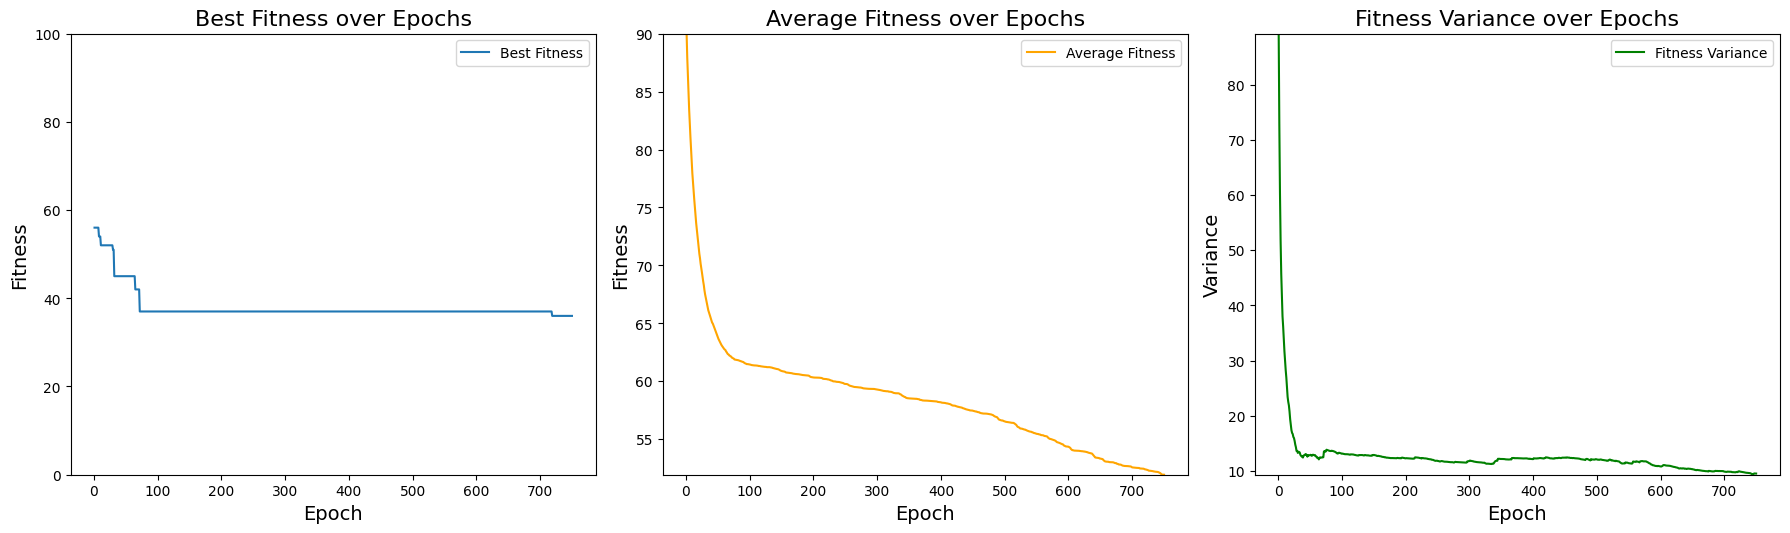

In [16]:
epochs_range = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.plot(epochs_range, all_best_fitness, label='Best Fitness')
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Fitness',fontsize=14)
plt.title('Best Fitness over Epochs',fontsize=16)
plt.legend()
plt.ylim(0, 100)  # Set y-axis limits for best fitness

plt.subplot(2, 3, 2)
plt.plot(epochs_range, all_avg_fitness, label='Average Fitness', color='orange')
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Fitness',fontsize=14)
plt.title('Average Fitness over Epochs',fontsize=16)
plt.legend()
plt.ylim(min(all_avg_fitness), max(all_avg_fitness))  # Adjust this range as needed

plt.subplot(2, 3, 3)
plt.plot(epochs_range, all_fitness_variance, label='Fitness Variance', color='green')
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Variance',fontsize=14)
plt.title('Fitness Variance over Epochs',fontsize=16)
plt.legend()
plt.ylim(min(all_fitness_variance), max(all_fitness_variance))  # Adjust this range as needed

plt.tight_layout()
plt.show()

In [17]:
total_time = end_time - start_time
average_runtime_per_epoch = total_time / EPOCHS
cumulative_runtime = np.linspace(average_runtime_per_epoch, total_time, EPOCHS)

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
axs[0].plot(cumulative_runtime, all_best_fitness, label='Best Fitness', color='purple')
axs[0].set_xlabel('Cumulative Runtime (seconds)',fontsize=14)
axs[0].set_ylabel('Best Fitness',fontsize=14)
axs[0].set_title('Best Fitness vs Runtime (750 Epochs)',fontsize=16)
axs[0].legend()
axs[0].set_ylim(0, 100)  


axs[1].plot(cumulative_runtime, all_best_fitness, label='Best Fitness', color='purple')
#axs[1].axvline(x=cumulative_runtime[751], color='red', linestyle='--', label='Epoch 750')
axs[1].set_xlabel('Cumulative Runtime (seconds)',fontsize=14)
axs[1].set_ylabel('Best Fitness',fontsize=14)
axs[1].set_title('Best Fitness vs Runtime (1000 Epochs)',fontsize=16)
axs[1].legend()
axs[1].set_ylim(0, 100)  

plt.tight_layout()

plt.show()



SyntaxError: invalid syntax. Perhaps you forgot a comma? (1299095348.py, line 12)